Al entregar la solución de este parcial, yo, Juan Martin Santos Ayala con código [#] me comprometo a no conversar durante el desarrollo de este examen con ninguna persona que no sea el profesor del curso, sobre aspectos relacionados con el parcial; tampoco utilizaré algún medio de comunicación por voz, texto o intercambio de archivos, para consultar o compartir con otros, información sobre el tema del parcial. Soy consciente y acepto las consecuencias que acarreará para mi desempeño académico cometer fraude en este parcial”. 

# Entendimiento de los datos

Alpes Air es una empresa que quiere saber si `los clientes estan satisfechos` con el servicio dado por la empresa. Por comenzaremos a realizar un analisis que nos permitira determinar utilizando tecnicas de machine learning, que aspectos hacen que un cliente este satisfecho con el servicio prestado por la arolinea

In [17]:
pip install ydata-profiling

Note: you may need to restart the kernel to use updated packages.


In [155]:
# Primero cargaremos los datos
import pandas as pd
import numpy as np
import ydata_profiling

from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, ElasticNet

from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import FunctionTransformer, Normalizer

In [2]:
# Ahora importamos los datos y los visulizamos
df = pd.read_csv('data/aplesair.csv',sep=';', encoding='utf-8', index_col=0)

In [3]:
# Observamos la estructura de los datos y sus columnas
df.sample(10)

Sexo TipoCliente  Edad TipoViaje               Clase  \
id                                                            
128868    M  Esporadico    29  Negocios           Ejecutiva   
78320     F   Frecuente    56  Negocios           Ejecutiva   
57604     M  Esporadico    20  Negocios           Economica   
105197    F   Frecuente    45  Negocios  MuyEconomicanomica   
91209     F   Frecuente    44  Personal           Economica   
128934    F   Frecuente    33  Negocios           Ejecutiva   
23538     M   Frecuente    53  Personal           Economica   
119598    F   Frecuente    49  Negocios           Ejecutiva   
36848         Frecuente    62  Negocios  MuyEconomicanomica   
121522    F   Frecuente    44  Negocios           Ejecutiva   

        DistanciaREconomicarrida  SatServicioWifi SatPuntualidad  \
id                                                                 
128868                      1443                0              0   
78320                       1547                3              4   
57604                        563                4              0   
105197                       289                4              5   
91209                        404                3              4   
128934                      2486                2              2   
23538                        423                5              2   
119598                      1979                1              1   
36848                        369                1              2   
121522                      3069                2              2   

        SatComidaBebidas  ComodidadSilla  SatEntretenimiento  \
id                                                             
128868                 0               2                   3   
78320                  3               3                   3   
57604                  5               5                   5   
105197                 3               4                   4   
91209                  2               3                   3   
128934                 3               5                   4   
23538                  4               4                   4   
119598                 3               5                   4   
36848                  1               1                   1   
121522                 2               5                   4   

        SatServicioAbordo  NivelLimpieza  MinRetrasoSalida  \
id                                                           
128868                  5              2                 0   
78320                   3              3                 0   
57604                   4              5                11   
105197                  4              1                 0   
91209                   3              1                 7   
128934                  4              3                 0   
23538                   1              4                 2   
119598                  4              5                 0   
36848                   3              1               155   
121522                  4              5                29   

                 satisfaccion  
id                             
128868             satisfecho  
78320   neutro o insatisfecho  
57604              satisfecho  
105197             satisfecho  
91209   neutro o insatisfecho  
128934             satisfecho  
23538              satisfecho  
119598             satisfecho  
36848   neutro o insatisfecho  
121522             satisfecho

In [21]:
airalpes = df

In [22]:
profile = ydata_profiling.ProfileReport(airalpes)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
airalpes = airalpes.dropna()

In [59]:
ordinalCat = ['TipoCliente','Clase','SatPuntualidad','satisfaccion']
oneHotCat = ['Sexo','TipoViaje']

def replace_gender(x):
    x = x.replace(['Male', 'Female',' '],['M','F', None])
    x = x.dropna()
    return x


ordinalEncoder = Pipeline([
    ('ordinal_enconde', OrdinalEncoder())
])

onehotEncoder = Pipeline([
    ('onehot_encoder', OneHotEncoder())
])

In [60]:
columns = airalpes.columns
columns.drop(['TipoCliente','Clase','SatPuntualidad','satisfaccion','Sexo','TipoViaje'])

Index(['Edad', 'DistanciaREconomicarrida', 'SatServicioWifi',
       'SatComidaBebidas', 'ComodidadSilla', 'SatEntretenimiento',
       'SatServicioAbordo', 'NivelLimpieza', 'MinRetrasoSalida'],
      dtype='object')

In [61]:
pipeline = Pipeline([
    ('gender_imputer', FunctionTransformer(replace_gender)),
    ('tranformer', ColumnTransformer([
        ('keep', 'passthrough', ['Edad', 'DistanciaREconomicarrida', 'SatServicioWifi','SatComidaBebidas', 'ComodidadSilla', 'SatEntretenimiento','SatServicioAbordo', 'NivelLimpieza', 'MinRetrasoSalida']),
        ('onehot_encode', onehotEncoder,oneHotCat),
        ("ordinal_encoder", ordinalEncoder, ordinalCat)
    ]))
])

df_airalpes = pipeline.fit_transform(airalpes)

In [62]:
df_airalpes.shape

(986, 17)

In [63]:
features = ['Edad', 'DistanciaREconomicarrida', 'SatServicioWifi','SatComidaBebidas',
            'ComodidadSilla', 'SatEntretenimiento','SatServicioAbordo', 'NivelLimpieza',
            'MinRetrasoSalida','Sexo_M','Sexo_F','TipoViaje_Negocios','TipoViaje_Personal',
            'TipoCliente','Clase','SatPuntualidad',"satisfaccion"
            ]

In [64]:
df_airalpes = pd.DataFrame(df_airalpes)
df_airalpes.columns = features
df_airalpes

Edad  DistanciaREconomicarrida  SatServicioWifi  SatComidaBebidas  \
0    16.0                    3192.0              3.0             300.0   
1     7.0                    1012.0              3.0               5.0   
2    39.0                    2204.0              1.0               3.0   
3     9.0                    2475.0              4.0               4.0   
4    56.0                    3344.0              0.0               3.0   
..    ...                       ...              ...               ...   
981  59.0                    3203.0              5.0               4.0   
982  40.0                     933.0              5.0               1.0   
983  17.0                     250.0              5.0               2.0   
984  36.0                     946.0              2.0               1.0   
985  28.0                     239.0              2.0               5.0   

     ComodidadSilla  SatEntretenimiento  SatServicioAbordo  NivelLimpieza  \
0               3.0                 3.0                3.0            3.0   
1               2.0                 5.0                2.0            5.0   
2               4.0                 4.0                4.0            3.0   
3               5.0                 1.0                5.0            5.0   
4               4.0                 2.0                2.0            5.0   
..              ...                 ...                ...            ...   
981             5.0                 2.0                2.0            3.0   
982             1.0                 1.0                3.0            1.0   
983             2.0                 2.0                4.0            2.0   
984             1.0                 1.0                3.0            1.0   
985             5.0                 5.0                5.0            5.0   

     MinRetrasoSalida  Sexo_M  Sexo_F  TipoViaje_Negocios  TipoViaje_Personal  \
0                31.0     0.0     1.0                 1.0                 0.0   
1                26.0     1.0     0.0                 0.0                 1.0   
2                 0.0     1.0     0.0                 1.0                 0.0   
3                 0.0     1.0     0.0                 0.0                 1.0   
4                 0.0     0.0     1.0                 1.0                 0.0   
..                ...     ...     ...                 ...                 ...   
981               7.0     1.0     0.0                 1.0                 0.0   
982               0.0     1.0     0.0                 0.0                 1.0   
983               0.0     0.0     1.0                 1.0                 0.0   
984               0.0     1.0     0.0                 0.0                 1.0   
985              31.0     0.0     1.0                 0.0                 1.0   

     TipoCliente  Clase  SatPuntualidad  satisfaccion  
0            1.0    1.0             2.0           0.0  
1            1.0    0.0             5.0           0.0  
2            1.0    1.0             1.0           1.0  
3            1.0    0.0             2.0           0.0  
4            1.0    1.0             5.0           1.0  
..           ...    ...             ...           ...  
981          1.0    1.0             5.0           1.0  
982          1.0    0.0             4.0           1.0  
983          0.0    0.0             4.0           1.0  
984          1.0    0.0             1.0           0.0  
985          1.0    0.0             5.0           0.0  

[986 rows x 17 columns]

Ya que tenemos todas las columnas, haremos el heatmap para determinar la correlacion entre las columnas y cuales pueden llegar a ser mas importantes en nuestro modelo.

<AxesSubplot:>

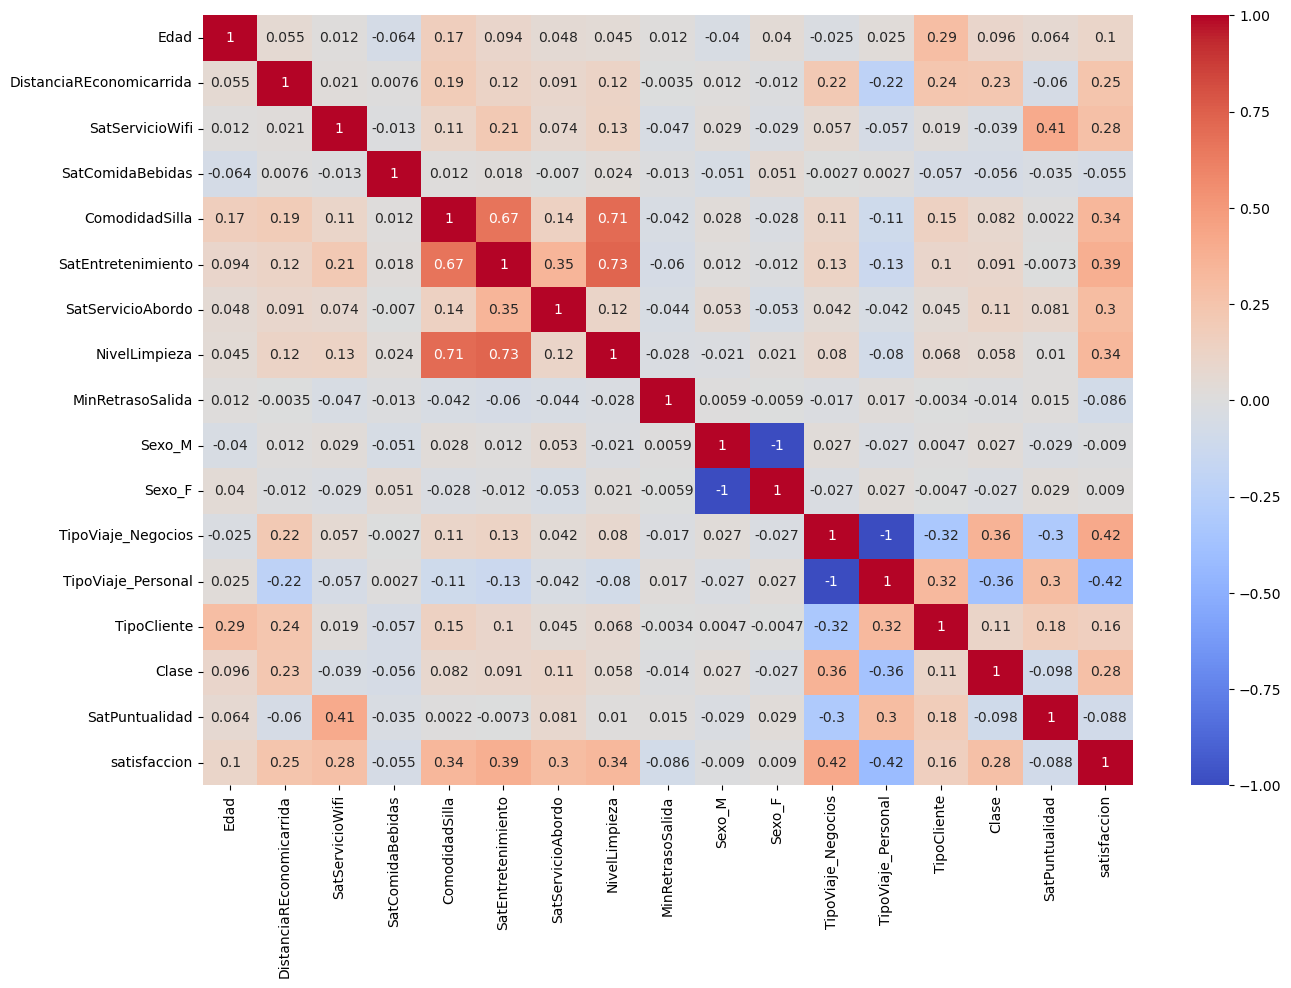

In [70]:
plt.figure(figsize =(15,10))
sns.heatmap(df_airalpes.corr(),cmap='coolwarm',annot=True)

Como podemos observar. Ahora tomaremos las columnas que mas correlacion tienen con el nivel de satisfaccion y haremos un modelo de regresion para determinar que tan exacto puede llegar a ser el modelo.

In [71]:
x_train, x_test, y_train, y_test = train_test_split(df_airalpes.drop(["satisfaccion"], axis=1),df_airalpes["satisfaccion"],test_size=0.3, random_state=1)

In [90]:
regre = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

regre.fit(x_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

0.4385374245432413


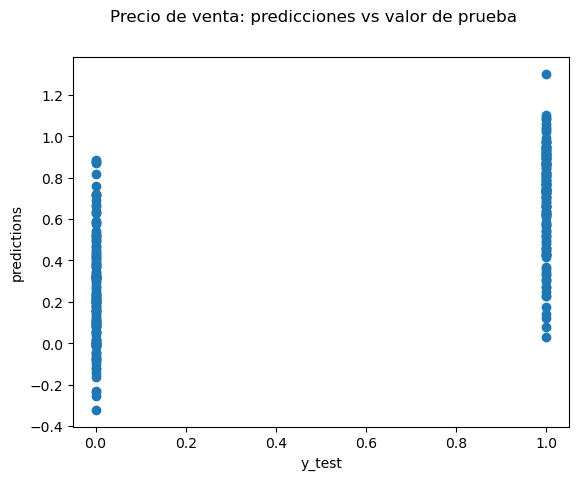

In [91]:
y_hat_norm = regre.predict(x_test)

fig = plt.figure()
fig.suptitle('Precio de venta: predicciones vs valor de prueba')
plt.xlabel('y_test')
plt.ylabel('predictions')
plt.scatter(y_test,y_hat_norm)

print(r2_score(y_test,y_hat_norm))

Ahora haremos el mismo modelo considerando solo las columnas que tienen mas correlacion

In [113]:
new_df = df_airalpes.drop(['Edad','SatComidaBebidas','MinRetrasoSalida','Sexo_M','Sexo_F','SatPuntualidad'], axis=1)

train, test, yTrain, yTest = train_test_split(new_df.drop('satisfaccion', axis=1), new_df['satisfaccion'],test_size=0.3, random_state=1)

In [208]:
regres = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=10))
])

regres.fit(x_train,y_train)
y_pred = regres.predict(x_test)
r2_score(y_test,y_pred)


0.721867039041929

In [209]:
feature_importances = regres.named_steps['rf'].feature_importances_

In [213]:
# Get the indices of the top k most important features
k = 5  # specify the desired number of top features
top_k_indices = feature_importances.argsort()[-k:][::-1]

# Get the names of the top k most important features
top_k_feature_names = x_train.columns[top_k_indices].tolist()

print(top_k_feature_names)

['SatServicioWifi', 'Clase', 'ComodidadSilla', 'NivelLimpieza', 'TipoCliente']


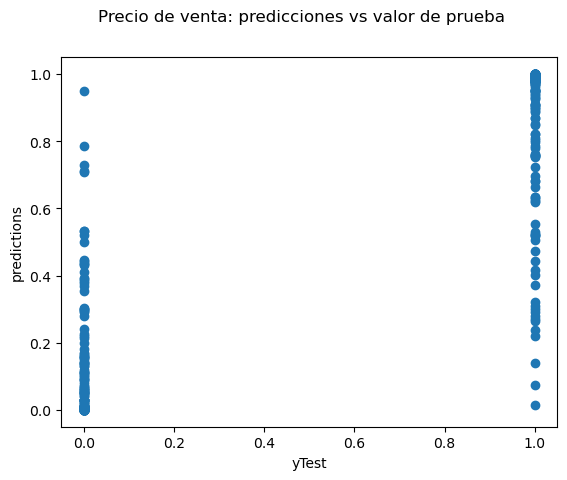

In [204]:
fig2 = plt.figure()
fig2.suptitle('Precio de venta: predicciones vs valor de prueba')
plt.xlabel('yTest')
plt.ylabel('predictions')
plt.scatter(yTest,y_pred)

KeyError: 'model'

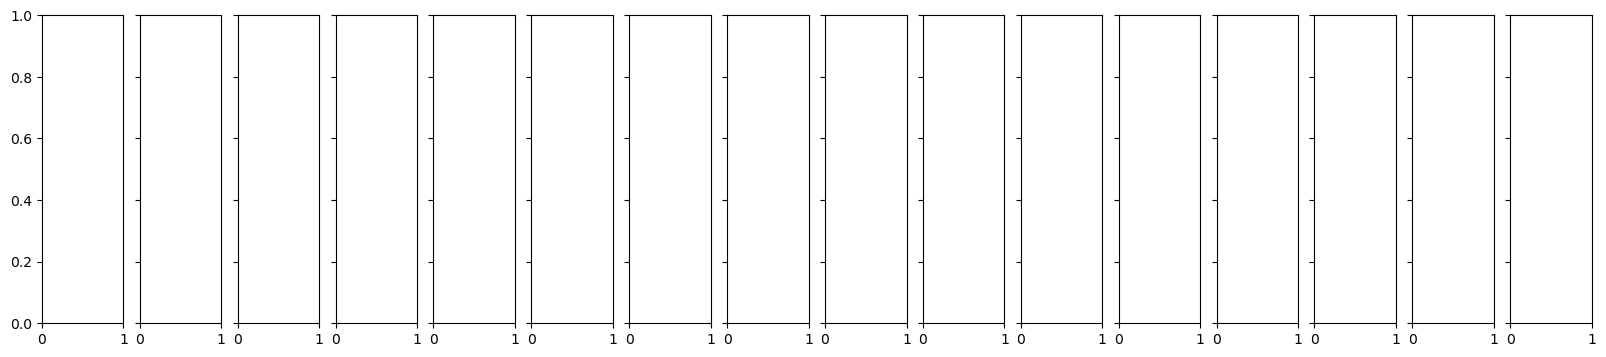

In [205]:
fichurs = ['Edad', 'DistanciaREconomicarrida', 'SatServicioWifi','SatComidaBebidas',
            'ComodidadSilla', 'SatEntretenimiento','SatServicioAbordo', 'NivelLimpieza',
            'MinRetrasoSalida','Sexo_M','Sexo_F','TipoViaje_Negocios','TipoViaje_Personal',
            'TipoCliente','Clase','SatPuntualidad'
            ]

f, axs = plt.subplots(1, len(fichurs), sharey = True, figsize = (20, 4))

for i in range(len(fichurs)):
    col = fichurs[i]
    x = x_train[col]
    m = regres['model'].coef_[i]
    b = regres['model'].intercept_

    axs[i].plot(x, y_train, 'o', alpha = 0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

ValueError: operands could not be broadcast together with shapes (690,) (10,) 

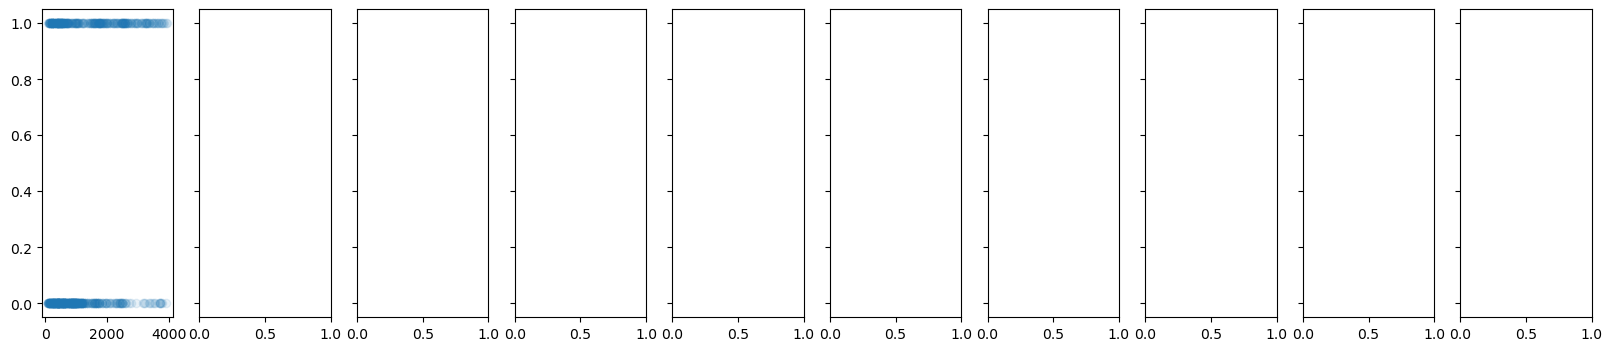

In [119]:
fichurs2 = ['DistanciaREconomicarrida', 'SatServicioWifi','ComodidadSilla', 'SatEntretenimiento','SatServicioAbordo','NivelLimpieza','TipoViaje_Negocios','TipoViaje_Personal','TipoCliente','Clase']

f, axs = plt.subplots(1, len(fichurs2), sharey = True, figsize = (20, 4))

for i in range(len(fichurs2)):
    col = fichurs2[i]
    x = train[col]
    m = regre2['model'].coef_[i]
    b = regre2['model'].intercept_

    axs[i].plot(x, yTrain, 'o', alpha = 0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)